# **Fine-tuning LaBSE Model on Russian-Chukchi Parallel Corpus**

Fine-tuning is performed using the **[lingtrain aligner](https://github.com/averkij/lingtrain-aligner)** library.

In [ ]:
!pip install seaborn more_itertools lingtrain-aligner==0.9.4 dateparser sentence_transformers sentencepiece transformers razdel datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.7/51.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

In [ ]:
!mkdir ckt
!mkdir img_alignment

mkdir: cannot create directory ‘ckt’: File exists
mkdir: cannot create directory ‘img_alignment’: File exists


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import time
from sentence_transformers import SentenceTransformer, SentencesDataset, LoggingHandler, losses
from sentence_transformers.readers import InputExample
from sentence_transformers.evaluation import SentenceEvaluator
from torch.utils.data import DataLoader
from datetime import datetime
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm import tqdm
import os
import logging
from warnings import simplefilter
import sys
from datasets import load_dataset

from lingtrain_aligner import preprocessor, splitter, aligner, resolver, reader, helper, vis_helper, metrics

sns.set_theme(style="darkgrid")

In [ ]:
# Configure logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
simplefilter(action="ignore", category=FutureWarning)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] - %(process)d: %(message)s",
    datefmt="%d-%b-%y %H:%M:%S",
    handlers=[
        logging.StreamHandler(sys.stdout),
        logging.FileHandler("_labse.log", mode="a"),
    ],
)
logging.getLogger("matplotlib.font_manager").disabled = True
logger = logging.getLogger(__name__)

In [ ]:
def flatten(arr):
    return [x for xs in arr for x in xs]

class ChainScoreEvaluator(SentenceEvaluator):
    """Evaluate a lingtrain chain score. This score calculates coefficient of unbrokenness."""
    def __init__(self, db_path, lang_from, lang_to, text1, text2, model, scores_1=[], scores_2=[], evaluation_steps=100):
        self.db_path = db_path
        self.lang_from = lang_from
        self.lang_to = lang_to
        self.text1 = text1
        self.text2 = text2
        self.scores_1 = scores_1
        self.scores_2 = scores_2
        self.best_score = 0.0
        self.model = model

    def __call__(self, model, output_path: str = None, epoch: int = -1, steps: int = -1) -> float:
        clear_output(wait=True)

        text1_prepared = preprocessor.mark_paragraphs(text1)
        text2_prepared = preprocessor.mark_paragraphs(text2)

        if self.lang_from=='san':
            splitted_from = flatten([x.split('.') for x in text1_prepared])
            splitted_from = [x.strip() + '.' for x in splitted_from]
        else:
            splitted_from = splitter.split_by_sentences_wrapper(text1_prepared, self.lang_from)
        splitted_to = splitter.split_by_sentences_wrapper(text2_prepared, self.lang_to)

        logger.info(f'Splitted length: {self.lang_from} — {len(splitted_from)}, {self.lang_to} — {len(splitted_to)}')

        if os.path.isfile(db_path):
            os.unlink(db_path)
        aligner.fill_db(db_path, self.lang_from, self.lang_to, splitted_from, splitted_to)

        start_time = time.time()

        batch_ids = range(0,1)
        aligner.align_db(db_path,
                        model_name='_',
                        batch_size=500,
                        window=50,             # tweak this parameter if needed
                        batch_ids=batch_ids,
                        save_pic=False,
                        embed_batch_size=100,
                        normalize_embeddings=True,
                        show_progress_bar=False,
                        shift=0,               # tweak this parameter if needed
                        model=self.model
                        )

        conflicts, rest = resolver.get_all_conflicts(db_path, min_chain_length=2, max_conflicts_len=6, batch_id=-1)
        logger.info(f'Resolving short conflicts for proper validation: {len(conflicts)} conflicts detected (min chains len are from 2 to 6).')
        resolver.resolve_all_conflicts(db_path, conflicts, model_name="_", show_logs=False, model=self.model)
        score_1 = metrics.chain_score(db_path)
        score_2 = metrics.chain_score(db_path, mode='both')
        logger.info(f"Epoch: {epoch} steps: {steps}.")

        if score_1 > self.best_score:
            self.best_score = score_1
            logger.info(f"Score 1: {score_1} new best score (#1).")
            if self.best_score > 0.06:
                logger.info("Saving the model...")
                model.save(f'output/best_model_{LANG_1}_{LANG_2}')
                logger.info(f"Model saved to output/best_model_{LANG_1}_{LANG_2}.")
        else:
            logger.info(f"score 1: {score_1}")

        logger.info(f"score 2: {score_2}")
        self.scores_1.append(score_1)
        self.scores_2.append(score_2)

        vis_helper.visualize_alignment_by_db(db_path,
                output_path="./img_alignment/alignment_vis_ckt.png",
                batch_size=400,
                size=(600,600),
                lang_name_from=self.lang_from,
                lang_name_to=self.lang_to,
                plt_show=True)

        # fig, ax=plt.subplots(1,2, figsize=(18, 5))

        if steps % evaluation_steps==0:
            sns.lineplot(data=self.scores_1)

        # if steps % evaluation_steps==0:
        #     sns.lineplot(data=self.scores_2, ax=ax[1])

        return score_1

## **Preparing the Dataset**

In [ ]:
import csv

In [ ]:
file_path = '/content/ru-ckt_final .csv'

In [ ]:
# Language names for the model
LANG_1 = 'ckt'
LANG_2 = 'ru'

# Column names in the dataset
DATASET_LANG_1 = 'ckt'
DATASET_LANG_2 = 'ru'

def prepare_dataset(file_path, feature_1, feature_2):
    res = []
    with open(file_path, 'r', encoding='utf-8') as f:
        reader = csv.reader(f, delimiter=';')

        for row in reader:
            lang1_text = row[1].strip()  # ckt sentence
            lang2_text = row[0].strip()  # ru sentence

            if (lang1_text.lower() == feature_1.lower() and lang2_text.lower() == feature_2.lower()) or not lang1_text or not lang2_text:
                continue

            res.append({feature_1: lang1_text, feature_2: lang2_text})

    return res

In [ ]:
train_dataset_orig = prepare_dataset(file_path, feature_1=DATASET_LANG_1, feature_2=DATASET_LANG_2)

In [ ]:
train_dataset_orig[:5]

[{'ckt': 'Ръэв ынкъам ӄораны', 'ru': 'Кит и олень'},
 {'ckt': 'Аӈӄачормэпы нылеӄин ӄораӈы, ръэв-ым аӈӄайпы ныӄолентоӄэн:',
  'ru': 'Олень шел по берегу моря, и кит крикнул:'},
 {'ckt': '- Китаӄун мынтэйкэвмык.', 'ru': 'давай сразимся.'},
 {'ckt': 'Мэӈин эплеэн армаӈ вальын!', 'ru': 'Кто сильнее - ты или я?'},
 {'ckt': '- Ээ!', 'ru': '- Хорошо!'}]

In [ ]:
len(train_dataset_orig)

69231

## **Loading the Original Model**

In [ ]:
model = SentenceTransformer('LaBSE')

31-May-25 07:57:02 [INFO] - 3545: Use pytorch device_name: cuda:0
31-May-25 07:57:02 [INFO] - 3545: Load pretrained SentenceTransformer: LaBSE


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.02k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


31-May-25 07:57:11 [WARNING] - 3545: Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


31-May-25 07:58:39 [WARNING] - 3545: Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


31-May-25 07:58:39 [WARNING] - 3545: Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

## **Fine-tuning the Model**

Here we prepare evaluation texts and configure fine-tuning parameters

Evaluation texts should be preprocessed (clean) and parallel (use common sense as guidance)

In [ ]:
db_path = f"alignment_{LANG_1}.db"
evaluation_steps = 100


input_file = "/content/chukot_article_19507.txt"

def read_combined_file(file_path, separator='ru:'):

    with open(file_path, "r", encoding="utf8") as f:
        lines = f.readlines()

    text1 = []
    text2 = []
    current_text = text1

    for line in lines:
        line = line.strip()
        if line == separator:
            current_text = text2
            continue
        if line:
            current_text.append(line)

    return text1, text2

text1, text2 = read_combined_file(input_file)

evaluator = ChainScoreEvaluator(db_path, LANG_1, LANG_2, text1, text2, model=model, evaluation_steps=evaluation_steps)

In [ ]:
num_epochs = 1
train_batch_size = 8
warmup_steps = 1000

train_examples = [InputExample(texts=[x[LANG_1], x[LANG_2]], label=1.0) for x in train_dataset_orig]
train_dataset = SentencesDataset(train_examples, model)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)
train_loss = losses.MultipleNegativesRankingLoss(model=model)

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

31-May-25 08:17:29 [INFO] - 3545: Splitted length: ckt — 35, ru — 40
31-May-25 08:17:29 [INFO] - 3545: Initializing database alignment_ckt.db
Aligning without segments.
tasks amount: 1
batch: 0 (0)
31-May-25 08:17:29 [INFO] - 3545: Batch 0. Calculating vectors.
31-May-25 08:17:29 [WARNING] - 3545: can not fetch index db
conflicts to solve: 4
total conflicts: 4
31-May-25 08:17:29 [INFO] - 3545: Resolving short conflicts for proper validation: 4 conflicts detected (min chains len are from 2 to 6).


100%|██████████| 4/4 [00:00<00:00, 21.13it/s]

31-May-25 08:17:29 [INFO] - 3545: Epoch: 1.0 steps: 8654.
31-May-25 08:17:29 [INFO] - 3545: score 1: 0.8974358974358975
31-May-25 08:17:29 [INFO] - 3545: score 2: 0.9459459459459459


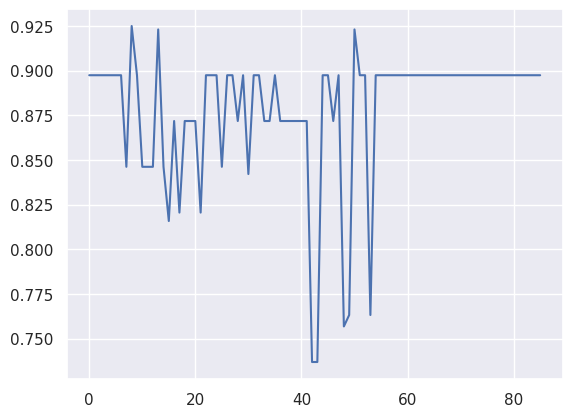

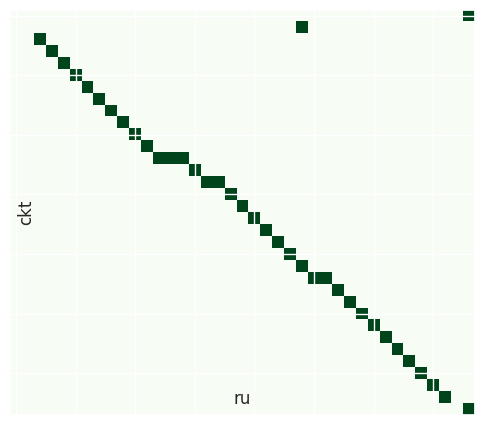

Step,Training Loss,Validation Loss,Evaluator
100,No log,No log,0.897436
200,No log,No log,0.897436
300,No log,No log,0.897436
400,No log,No log,0.897436
500,1.660100,No log,0.897436
600,1.660100,No log,0.897436
700,1.660100,No log,0.897436
800,1.660100,No log,0.846154
900,1.660100,No log,0.925000
1000,1.111700,No log,0.897436


In [ ]:
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=evaluation_steps,
          save_best_model=False,
          use_amp=True,
          warmup_steps=warmup_steps,
          scheduler = 'warmupcosine',
          optimizer_params = {'lr': 2e-5}, # default 2e-5   #3e-4
          )

## **Saving the Model Locally**

In [ ]:
model.save("ckt_labse_prepared_dataset")

29-May-25 16:54:58 [INFO] - 678: Save model to ckt_labse_prepared_dataset


In [ ]:
!zip -r ckt_labse_prepared_dataset.zip ckt_labse_prepared_dataset

  adding: ckt_labse_prepared_dataset/ (stored 0%)
  adding: ckt_labse_prepared_dataset/2_Dense/ (stored 0%)
  adding: ckt_labse_prepared_dataset/2_Dense/config.json (deflated 26%)
  adding: ckt_labse_prepared_dataset/2_Dense/model.safetensors (deflated 7%)
  adding: ckt_labse_prepared_dataset/config.json (deflated 53%)
  adding: ckt_labse_prepared_dataset/vocab.txt (deflated 43%)
  adding: ckt_labse_prepared_dataset/modules.json (deflated 68%)
  adding: ckt_labse_prepared_dataset/tokenizer_config.json (deflated 75%)
  adding: ckt_labse_prepared_dataset/1_Pooling/ (stored 0%)
  adding: ckt_labse_prepared_dataset/1_Pooling/config.json (deflated 57%)
  adding: ckt_labse_prepared_dataset/README.md (deflated 64%)
  adding: ckt_labse_prepared_dataset/sentence_bert_config.json (deflated 4%)
  adding: ckt_labse_prepared_dataset/tokenizer.json (deflated 65%)
  adding: ckt_labse_prepared_dataset/special_tokens_map.json (deflated 80%)
  adding: ckt_labse_prepared_dataset/model.safetensors (deflat

## **Saving the Model to Google Drive**

In [ ]:
model.save("/content/drive/MyDrive/ckt_labse_final_dataset")

31-May-25 08:17:29 [INFO] - 3545: Save model to /content/drive/MyDrive/ckt_labse_final_dataset


## **Uploading the Model to Hugging Face**

If needed, load the model from Google Drive:

In [ ]:
# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer("/content/drive/MyDrive/ckt_labse_final_dataset")

In [ ]:
!pip install huggingface_hub

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from huggingface_hub import HfApi

api = HfApi()
api.create_repo(repo_id="HSE-Chukchi-NLP/LaBSE-russian-chukchi", repo_type="model", exist_ok=True)

api.upload_folder(
    folder_path="/content/drive/MyDrive/ckt_labse_final_dataset",
    repo_id="HSE-Chukchi-NLP/LaBSE-russian-chukchi",
    repo_type="model"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/13.6M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/HSE-Chukchi-NLP/LaBSE-russian-chukchi/commit/fcb9977701289814bbd58860a2970073b8b1578c', commit_message='Upload folder using huggingface_hub', commit_description='', oid='fcb9977701289814bbd58860a2970073b8b1578c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/HSE-Chukchi-NLP/LaBSE-russian-chukchi', endpoint='https://huggingface.co', repo_type='model', repo_id='HSE-Chukchi-NLP/LaBSE-russian-chukchi'), pr_revision=None, pr_num=None)